## Mean / Median imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. Its goal is to produce a **complete dataset**. If the variable has a **Gaussian distribution**, we replace by the **mean**, if the variable has a **skewed distribution** by **median**. Replacing missing data by the mode is not common practice for  numerical variables. For **discrete variables** casted as 'int' (to save memory), the mean may not be an integer, therefore the whole variable will be re-casted as 'float'. In order to avoid this behaviour, **we can replace NA with the median instead**. The median will inevitably be an integer / discrete value as well. **The mean and median can only be calculated on continuous or discrete numerical variables, only.** Data should be missing completely at random (MCAR).

It is easy to implement and fast. It can be integrated in production (during model deployment). But **it distorts the original variable distribution and variance*, and also the covariance** with the remaining variables of the dataset. It can **increase outliers**. If data is **missing completely at random** and **no more than 5% **of the variable contains missing data, we can use it.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Titanic

In [2]:
data = pd.read_csv('titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
data.isnull().mean()  # the percentage of NA

survived    0.000000
age         0.200917
fare        0.000764
dtype: float64

The only variable with missing data is Age, with ~20% of missing observations.

### Imputation important

**Imputation should be done over the training set**, and then propagated to the test set. This means that the **mean / median** to be used to fill missing values both in train and test set, **should be extracted from the train set only**. And this is to avoid overfitting.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(      # Separate
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility
X_train.shape, X_test.shape

((916, 2), (393, 2))

**Explore the missing data percentages. It should be fairly similar!**

In [5]:
X_train.isnull().mean()

age     0.191048
fare    0.000000
dtype: float64

In [6]:
def impute_na(df, variable, mean_median):  # It fills with mean or median!
    return df[variable].fillna(mean_median)

In [7]:
median = X_train.age.median() # calculate the median Age
median

28.0

In [8]:
mean = X_train.age.mean()  # calculate the mean Age
mean

30.23144399460189

In [9]:
X_train['Age_median'] = impute_na(X_train, 'age', median)# Replace with median
X_train['Age_mean'] = impute_na(X_train, 'age', mean)  # Replace with mean
X_train['Age_mean'] = np.round(X_train['Age_mean'], 1) # Many decimals, round to 1
X_train.head(15)

,age,fare,Age_median,Age_mean
501,13.0,19.5000,13.0,13.0
588,4.0,23.0000,4.0,4.0
402,30.0,13.8583,30.0,30.0
1193,NaN,7.7250,28.0,30.2
686,22.0,7.7250,22.0,22.0
971,NaN,7.8792,28.0,30.2
117,30.0,56.9292,30.0,30.0
540,2.0,26.0000,2.0,2.0
294,49.0,110.8833,49.0,49.0
261,35.0,26.2875,35.0,35.0


Look at the rows with missing data (NaN) in Age, and see how in the new variables those were replaced by either 28 (median) or 30 (mean).

**Variance change  after mean/median imputation (missing data ~20%, Age) !**

In [10]:
print('Original variable variance: ', X_train['age'].var())
print('Variance after median imputation: ', X_train['Age_median'].var())
print('Variance after mean imputation: ', X_train['Age_mean'].var())

Original variable variance:  194.16304666581854
Variance after median imputation:  157.7984295760209
Variance after mean imputation:  157.02170735199397


As expected, the variance is underestimated, because now many values are the same ==> either the mean or the median value.

**Distribution change with  median or median!**

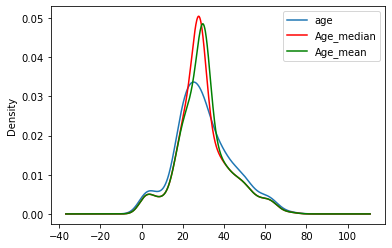

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['age'].plot(kind='kde', ax=ax)  # original variable distribution
X_train['Age_median'].plot(kind='kde', ax=ax, color='red') # with the median
X_train['Age_mean'].plot(kind='kde', ax=ax, color='green')  # with the mean
lines, labels = ax.get_legend_handles_labels()   # legends
ax.legend(lines, labels, loc='best')

As mentioned above, the mean / median imputation distorts the original distribution of the variable Age. The transformed variable shows more values around the mean / median values.

**Is this important?**

It depends on the machine learning model you want to build. Linear models assume that the variables are normally distributed. Mean / median imputation may distort the original normal distribution if the % of missing data is high. Therefore the final imputed variable will no longer be normally distributed, which in turn **may affect the linear model performance**.

**It may affect the relationship with the other variables!**

In [12]:
X_train[['fare', 'age', 'Age_median', 'Age_mean']].cov()

,fare,age,Age_median,Age_mean
fare,2248.326729,136.176223,114.961682,110.198311
age,136.176223,194.163047,194.163047,194.159033
Age_median,114.961682,194.163047,157.798430,157.035694
Age_mean,110.198311,194.159033,157.035694,157.021707


We see indeed that the covariance between Age and Fare is changed after the mean / median imputation.

**Increases outliers!**

<AxesSubplot:>

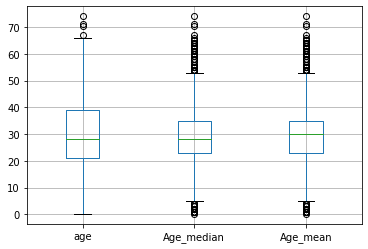

In [13]:
X_train[['age', 'Age_median', 'Age_mean']].boxplot()

From the boxplot above, we can see that after the imputation not only we have more outliers on the higher Age values, but we have now outliers as well for the lower values of Age.

## House Prices Dataset

Let's repeat the exercise in the House Prices dataset from. In this dataset, there are variables with a lot or with few missing data. Therefore we can compare the effect of mean / median imputation in both scenarios.

**Use only the following variables, 3 of which contain NA!**

In [14]:
cols_to_use = ['OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
               'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice']

**let's load the House Prices dataset!**

In [15]:
data = pd.read_csv('C:\\Users\\husey\\Desktop\\python\\udemy\\6.FeatureEngineeringForML\\HousingPrices_train.csv', usecols=cols_to_use)
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


**Print the variables that contain missing data!**

In [16]:
[var for var in data.columns if data[var].isnull().sum() > 0]

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

**Find the percentage of missing data!**

In [17]:
data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

**Remember that the mean and the median that we will use to replace the NA needs to be calculated in the train set and propagated to the test set.**

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 10), (438, 10))

**Let's plot the distributions of the variables!**

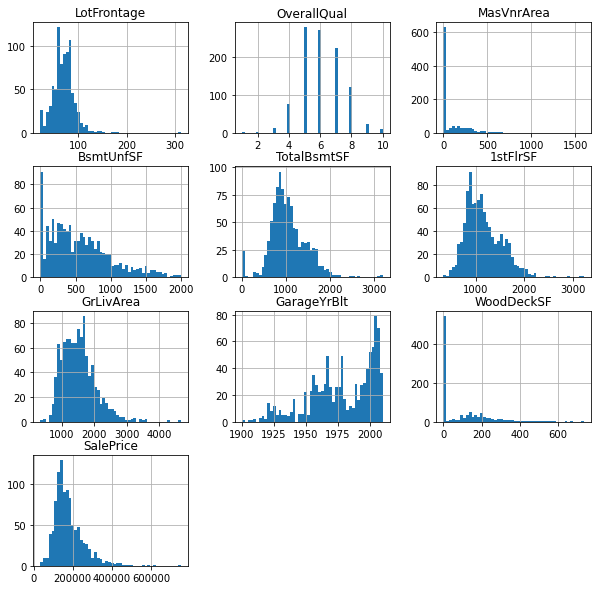

In [19]:
X_train.hist(bins=50, figsize=(10,10))
plt.show()

**Create a new variable with the missing values replaced by the median!**

In [21]:
median = X_train['LotFrontage'].median()
X_train.loc[:,'LotFrontage_median'] = impute_na(X_train, 'LotFrontage', median)
X_test.loc[:,'LotFrontage_median'] = impute_na(X_test, 'LotFrontage', median)

C:\Users\husey\anaconda3\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [22]:
median = X_train['MasVnrArea'].median()
X_train.loc[:,'MasVnrArea_median'] = impute_na(X_train, 'MasVnrArea', median)
X_test.loc[:,'MasVnrArea_median'] = impute_na(X_test, 'MasVnrArea', median)

In [23]:
median = X_train['GarageYrBlt'].median()
X_train.loc[:, 'GarageYrBlt_median'] = impute_na(X_train, 'GarageYrBlt', median)
X_test.loc[:,'GarageYrBlt_median'] = impute_na(X_test, 'GarageYrBlt', median)

**The effect of median imputation on the distribution!**

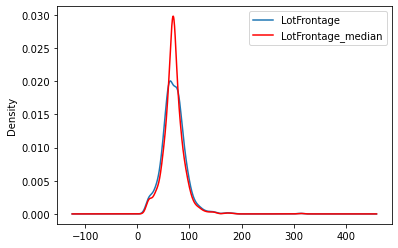

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax) # original variable dist.
X_train['LotFrontage_median'].plot(kind='kde', ax=ax, color='red')  # median
lines, labels = ax.get_legend_handles_labels()  # add legends
ax.legend(lines, labels, loc='best')

**For MasVnrArea, missing data is low, no much change!**

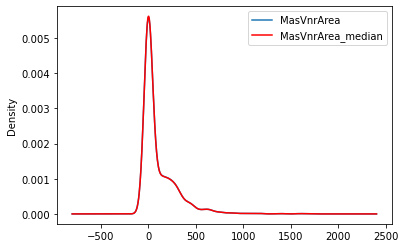

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['MasVnrArea'].plot(kind='kde', ax=ax)  # original variable dist.
X_train['MasVnrArea_median'].plot(kind='kde', ax=ax, color='red') # median
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

**Similarly, for GarageBlt !**

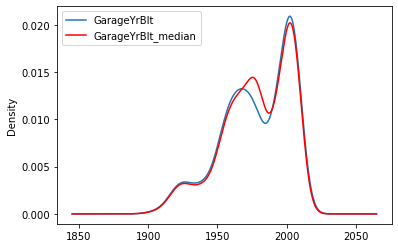

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['GarageYrBlt'].plot(kind='kde', ax=ax)
X_train['GarageYrBlt_median'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

Explore the **effect of the imputation technique on the variance** (LotFrontAge with the **high percentage of missing data**, ~20%)!**

In [28]:
print('Original Variance: ', X_train['LotFrontage'].var())
print('Variance after median imputation: ', X_train['LotFrontage_median'].var())

Original Variance:  532.5872021885676
Variance after median imputation:  434.06604265416564


**For MasnVnrArea, the % of missing data was small !!**

In [29]:
print('Original Variance: ', X_train['MasVnrArea'].var())
print('Variance after median imputation: ', X_train['MasVnrArea_median'].var())

Original Variance:  32983.538710039466
Variance after median imputation:  32874.27007404175


**For GarageBlt, the % of missing data was small so the effectis also be small !**

In [30]:
# for GarageBlt, the % of missing data was small so the effectis also be small !
print('Original Variance: ', X_train['GarageYrBlt'].var())
print('Variance after median imputation: ', X_train['GarageYrBlt_median'].var())

Original Variance:  624.3059475074134
Variance after median imputation:  591.3356883144767


**Explore the covariance!**

In [31]:
X_train.cov()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice,LotFrontage_median,MasVnrArea_median,GarageYrBlt_median
LotFrontage,532.587202,6.587119,6.805603e+02,9.496573e+02,2.908856e+03,3.379794e+03,3.919952e+03,30.611717,1.347414e+02,6.689645e+05,532.587202,6.744233e+02,28.095264
OverallQual,6.587119,1.843859,1.014970e+02,1.746147e+02,2.886241e+02,2.242973e+02,4.091242e+02,17.902809,3.168557e+01,8.320132e+04,5.384774,1.005330e+02,16.875386
MasVnrArea,680.560330,101.496976,3.298354e+04,7.540788e+03,2.478877e+04,2.086595e+04,3.520785e+04,1203.583792,3.208924e+03,6.836439e+06,553.921303,3.298354e+04,1134.380889
BsmtUnfSF,949.657293,174.614725,7.540788e+03,1.875241e+05,7.513307e+04,4.987449e+04,5.203392e+04,1823.065167,-1.833201e+03,6.833028e+06,788.095358,7.472110e+03,1724.141544
TotalBsmtSF,2908.855504,288.624075,2.478877e+04,7.513307e+04,1.682931e+05,1.212079e+05,8.615192e+04,3173.042442,1.227966e+04,2.003928e+07,2370.929189,2.465436e+04,2989.473391
1stFlrSF,3379.793504,224.297266,2.086595e+04,4.987449e+04,1.212079e+05,1.398656e+05,1.044401e+05,2009.195552,1.109406e+04,1.783631e+07,2750.747094,2.080136e+04,1890.271636
GrLivArea,3919.951834,409.124216,3.520785e+04,5.203392e+04,8.615192e+04,1.044401e+05,2.681277e+05,2738.982988,1.558395e+04,2.934477e+07,3189.685753,3.496714e+04,2576.345636
GarageYrBlt,30.611717,17.902809,1.203584e+03,1.823065e+03,3.173042e+03,2.009196e+03,2.738983e+03,624.305948,6.658911e+02,9.309355e+05,24.755173,1.182673e+03,624.305948
WoodDeckSF,134.741376,31.685571,3.208924e+03,-1.833201e+03,1.227966e+04,1.109406e+04,1.558395e+04,665.891118,1.648582e+04,3.029981e+06,106.009105,3.212101e+03,627.624634
SalePrice,668964.454191,83201.317781,6.836439e+06,6.833028e+06,2.003928e+07,1.783631e+07,2.934477e+07,930935.489321,3.029981e+06,6.105731e+09,544838.836893,6.790442e+06,877485.418108


**Explore the knock-on effect on outliers!**

<AxesSubplot:>

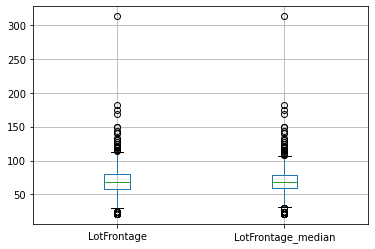

In [32]:
X_train[['LotFrontage', 'LotFrontage_median']].boxplot()

<AxesSubplot:>

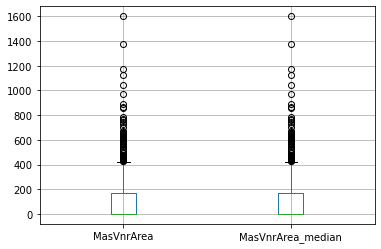

In [33]:
X_train[['MasVnrArea', 'MasVnrArea_median']].boxplot()

<AxesSubplot:>

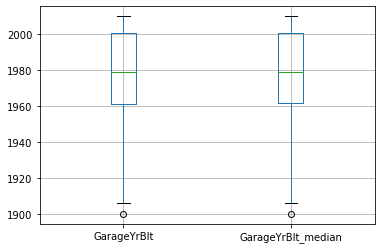

In [34]:
X_train[['GarageYrBlt', 'GarageYrBlt_median']].boxplot()